In [236]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from dotenv import load_dotenv

Definimos la semilla

In [237]:
# Cargamos las variables de entorno
load_dotenv(dotenv_path='./../variables.env')

seed = int(os.getenv("SEED"))

def set_seed():
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()


# Load Data

In [238]:
# Cargar el dataset MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalizar las imágenes a un rango de 0 a 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Si las imágenes son de una sola canal (escala de grises), necesitas agregar una dimensión extra
# para que sean compatibles con las capas de convolución de Keras
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

5
(28, 28, 1)


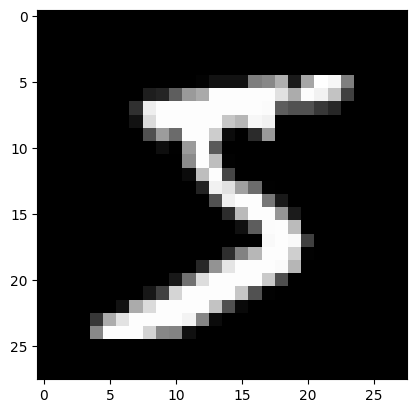

In [239]:
plt.imshow(X_train[0], cmap='gray')
print(y_train[0])
print(X_train[0].shape)

# Modelos

In [240]:
# Definimos los modelos

# seteamos la semilla
set_seed()
# Creamos el modelo de red neuronal Alta precisión
model_good = keras.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(128, activation='sigmoid'),
  keras.layers.Dense(10, activation='softmax')
])

# seteamos la semilla
set_seed()
# Creamos el modelo de red neuronal Media precisión
model_medium = keras.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(99, activation='softmax', kernel_initializer='ones', bias_initializer='ones'),
  keras.layers.Dense(28, activation='linear', kernel_initializer='ones', bias_initializer='ones'),
  keras.layers.Dense(10, activation='softmax')
])

# seteamos la semilla
set_seed()
# Creamos el modelo de red neuronal Baja precisión
model_bad = keras.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(33, activation='elu', kernel_initializer='ones', bias_initializer='ones'),
  keras.layers.Dense(88, activation='sigmoid', kernel_initializer='ones', bias_initializer='ones'),
  keras.layers.Dense(10, activation='softmax')
])


# Predecimos los modelos antes de entrenarlos

## Técnica de estimación
Programamos SynFlow

In [241]:
def linearize(model):
  """ 
    Get the absolute value of the weights of the model and return the signs of the weights 
  """
  signs = []
  for layer in model.layers:
    if len(layer.get_weights()) > 0:
      weights = layer.get_weights()
      layer_signs = [np.sign(w) for w in weights]
      new_weights = [np.abs(w) for w in weights]
      layer.set_weights(new_weights)
      signs.append(layer_signs)
  return signs


def compute_synflow_per_weight(model, input_shape):
  signs = linearize(model) # Get the signs of the weights and transform the absolute value of the weights

  inputs = np.ones((1,)+input_shape)
  with tf.GradientTape() as tape:
    trainable_variables = [tf.Variable(v) for v in model.trainable_variables]
    tape.watch(trainable_variables)
    outputs = model(inputs)
    loss = tf.reduce_sum(outputs)
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply gradient clipping to avoid numerical instability
  grads = [tf.clip_by_value(grad, -1.0, 1.0) for grad in grads]

  # Diagnostic prints for gradients and weights
  for i, g in enumerate(grads):
    print(f"Gradient of layer {i}: {g.numpy()}")
    if np.isnan(g.numpy()).any():
      print(f"NaN detected in gradient of layer {i}: {g.numpy()}")
      # Pause and wait for user input
      print("Model summary:")
      model.summary()
      input("NaN detected. Press enter to continue...")
      return None
    
  for i, w in enumerate(model.trainable_variables):
    print(f"Weights of layer {i}: {w.numpy()}")
    if np.isnan(w.numpy()).any():
      print(f"NaN detected in weights of layer {i}: {w.numpy()}")
      # Pause and wait for user input
      print("Model summary:")
      model.summary()
      for i, g in enumerate(grads):
        print(f"Gradient of layer {i}: {g.numpy()}")
      input("NaN detected. Press enter to continue...")
      return None
      
    synflow_scores = [np.abs(w.numpy() * g.numpy()) for w, g in zip(model.trainable_variables, grads)]

    return synflow_scores

### Predicción de redes

In [242]:
import prettytable as pt

input_shape = (28, 28, 1)

score_model_good = compute_synflow_per_weight(model_good, input_shape)
score_model_medium = compute_synflow_per_weight(model_medium, input_shape)
score_model_bad = compute_synflow_per_weight(model_bad, input_shape)

# Score por capa
table = pt.PrettyTable()
table.field_names = ["Layer", "Good model"]
for i, score in enumerate(score_model_good):
  table.add_row([f"Layer {i}", np.sum(score)])
print(table)

table = pt.PrettyTable()
table.field_names = ["Layer", "Medium model"]
for i, score in enumerate(score_model_medium):
  table.add_row([f"Layer {i}", np.sum(score)])
print(table)

table = pt.PrettyTable()
table.field_names = ["Layer", "Bad model"]
for i, score in enumerate(score_model_bad):
  table.add_row([f"Layer {i}", np.sum(score)])
print(table)

# Score total
score_model_good = [np.sum(score) for score in score_model_good]
score_model_medium = [np.sum(score) for score in score_model_medium]
score_model_bad = [np.sum(score) for score in score_model_bad]

# Score total
table = pt.PrettyTable()
table.field_names = ["Model", "Synflow score"]
table.add_row(["Good model", np.sum(score_model_good)])
table.add_row(["Medium model", np.sum(score_model_medium)])
table.add_row(["Bad model", np.sum(score_model_bad)])
print(table)

Gradient of layer 0: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Gradient of layer 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Gradient of layer 2: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Gradient of layer 3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Weights of layer 0: [[0.0627376  0.02128818 0.02913707 ... 0.06795544 0.07496486 0.07485852]
 [0.08061031 0.04484165 0.04038415 ... 0.04493705 0.07403212 0.03695085]
 [0.07491503 0.

## Modelo de alta precisión

In [243]:

model_good.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

params = {
  'batch_size': 32,
  'validation_data': (X_test, y_test),
  'epochs': 5
}

# Entrenamos el modelo
model_good.fit(X_train, y_train, **params)
loss, accuracy = model_good.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.7706 - loss: 0.8538 - val_accuracy: 0.9326 - val_loss: 0.2320
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.9376 - loss: 0.2181 - val_accuracy: 0.9503 - val_loss: 0.1700
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - accuracy: 0.9541 - loss: 0.1584 - val_accuracy: 0.9598 - val_loss: 0.1370
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9646 - loss: 0.1229 - val_accuracy: 0.9638 - val_loss: 0.1167
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.9725 - loss: 0.0988 - val_accuracy: 0.9679 - val_loss: 0.1034
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.9644 - loss: 0.1140
Loss: 0.10342215746641159, Accuracy: 0.9678999781608582


## Modelo de media precisión

In [244]:
# seteamos la semilla
set_seed()

model_medium.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

params = {
  'batch_size': 32,
  'validation_data': (X_test, y_test),
  'epochs': 5
}

# Entrenamos el modelo
model_medium.fit(X_train, y_train, **params)
loss, accuracy = model_medium.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 820us/step - accuracy: 0.1789 - loss: 2.0980 - val_accuracy: 0.2151 - val_loss: 1.7503
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step - accuracy: 0.2806 - loss: 1.7198 - val_accuracy: 0.3215 - val_loss: 1.6314
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.3271 - loss: 1.6142 - val_accuracy: 0.3762 - val_loss: 1.5521
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.3846 - loss: 1.5444 - val_accuracy: 0.4188 - val_loss: 1.5171
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.4186 - loss: 1.5122 - val_accuracy: 0.4363 - val_loss: 1.5077
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.4286 - loss: 1.5523
Loss: 1.507683277130127, Accuracy: 0.43630000948905945


## Modelo de baja precisión

In [245]:
# seteamos la semilla
set_seed()

model_bad.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

params = {
  'batch_size': 32,
  'validation_data': (X_test, y_test),
  'epochs': 5
}

# Entrenamos el modelo
model_bad.fit(X_train, y_train, **params)
loss, accuracy = model_bad.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 620us/step - accuracy: 0.1021 - loss: 2.3128 - val_accuracy: 0.1010 - val_loss: 2.3176
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - accuracy: 0.1039 - loss: 2.3122 - val_accuracy: 0.1010 - val_loss: 2.3176
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step - accuracy: 0.1040 - loss: 2.3122 - val_accuracy: 0.1010 - val_loss: 2.3176
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - accuracy: 0.1039 - loss: 2.3122 - val_accuracy: 0.1010 - val_loss: 2.3176
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.1039 - loss: 2.3122 - val_accuracy: 0.1010 - val_loss: 2.3176
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.1009 - loss: 2.3203
Loss: 2.3176376819610596, Accuracy: 0.10100000351667404
